Привет! Делюсь собственным вариантом решения задачи о Титанике с Kaggle. Надеюсь, он будет вам полезен.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import seaborn as sns
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import (
    recall_score,
    precision_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
)
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV, cross_validate
from scipy.stats import randint
import shap

random.seed(42)
np.random.seed(42)

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


1. Анализ и предобработка данных

In [4]:
train_df = pd.read_csv("/content/drive/MyDrive/titanic/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/titanic/test.csv")
submission = pd.read_csv('/content/drive/MyDrive/titanic/gender_submission.csv')
train_df.drop('PassengerId',axis=1,inplace=True)
test_df.drop('PassengerId',axis=1,inplace=True)
train_df.drop('Name',axis=1,inplace=True)
test_df.drop('Name',axis=1,inplace=True)
train_df.head(10)

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,female,35.0,1,0,113803,53.1000,C123,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S
5,0,3,male,NaN,0,0,330877,8.4583,NaN,Q
6,0,1,male,54.0,0,0,17463,51.8625,E46,S
7,0,3,male,2.0,3,1,349909,21.0750,NaN,S
8,1,3,female,27.0,0,2,347742,11.1333,NaN,S
9,1,2,female,14.0,1,0,237736,30.0708,NaN,C


Рассмотрим описательные характеристики для каждого признака. На первый взгляд сложно определить наличие явных выбросов в данных, поэтому далее проанализируем распределения признаков более подробно.

In [5]:
train_df.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Пропуски в признаке *Возраст* будут заполнены медианными значениями. Признак *Каюта* стоит рассмотреть отдельно: вероятно, у пассажиров самого низкого класса каюты действительно отсутствовали.

In [6]:
train_df.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0
Cabin,687
Embarked,2


In [7]:
test_df.isna().sum()

,0
Pclass,0
Sex,0
Age,86
SibSp,0
Parch,0
Ticket,0
Fare,1
Cabin,327
Embarked,0


Как и ожидалось, у пассажиров третьего класса комфорта отсутствовала закреплённая каюта, поэтому в колонке *Каюта* наблюдаются пропуски.

In [8]:
train_df[train_df['Cabin'].isna()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,3,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,0,3,male,35.0,0,0,373450,8.0500,NaN,S
5,0,3,male,NaN,0,0,330877,8.4583,NaN,Q
7,0,3,male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...
884,0,3,male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,0,3,female,39.0,0,5,382652,29.1250,NaN,Q
886,0,2,male,27.0,0,0,211536,13.0000,NaN,S
888,0,3,female,NaN,1,2,W./C. 6607,23.4500,NaN,S


Для пассажиров третьего класса пропуски в признаке Cabin будут заполнены значением "Unknown".

In [9]:
train_df.loc[(train_df['Pclass'] == 3) & (train_df['Cabin'].isna()), 'Cabin'] = "Unknown"
test_df.loc[(test_df['Pclass'] == 3) & (test_df['Cabin'].isna()), 'Cabin'] = "Unknown"

In [10]:
train_df['Cabin'].isna().sum()

np.int64(208)

In [11]:
test_df['Cabin'].isna().sum()

np.int64(113)

На данный момент в данных осталось 208 пропусков. Мы рассмотрим их более подробно немного позже.

Для пассажиров, у которых отсутствует значение Embarked, можно предположить, что они не сели на корабль, и, следовательно, выжили

In [12]:
train_df[train_df['Embarked'].isna()]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,1,1,female,38.0,0,0,113572,80.0,B28,NaN
829,1,1,female,62.0,0,0,113572,80.0,B28,NaN


Пропуски в признаке Embarked будут заполнены категорией "Unknown_port".

In [13]:
train_df['Embarked'].fillna('Unknown_port',inplace=True)
test_df['Embarked'].fillna('Unknown_port',inplace=True)

/tmp/ipython-input-3406797101.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_df['Embarked'].fillna('No_board',inplace=True)
/tmp/ipython-input-3406797101.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', tr

In [14]:
train_df.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0
Cabin,208
Embarked,0


Необходимо выяснить, почему у пассажиров более высокого класса отсутствуют данные о каютах. Вероятно, у пассажиров среднего и высокого классов каюты были закреплены, а пропуски в этих значениях можно рассматривать как случайные ошибки. Такие пропуски будут заполнены наиболее часто встречающимся значением (модой).

In [15]:
train_df[(train_df['Cabin'].isna()) & (train_df['Pclass']!= 3)]

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
9,1,2,female,14.0,1,0,237736,30.0708,NaN,C
15,1,2,female,55.0,0,0,248706,16.0000,NaN,S
17,1,2,male,NaN,0,0,244373,13.0000,NaN,S
20,0,2,male,35.0,0,0,239865,26.0000,NaN,S
30,0,1,male,40.0,0,0,PC 17601,27.7208,NaN,C
...,...,...,...,...,...,...,...,...,...,...
866,1,2,female,27.0,1,0,SC/PARIS 2149,13.8583,NaN,C
874,1,2,female,28.0,1,0,P/PP 3381,24.0000,NaN,C
880,1,2,female,25.0,0,1,230433,26.0000,NaN,S
883,0,2,male,28.0,0,0,C.A./SOTON 34068,10.5000,NaN,S


In [16]:
mode_class1 = train_df[train_df['Pclass'] == 1]['Cabin'].mode()[0]

mode_class2 = train_df[train_df['Pclass'] == 2]['Cabin'].mode()[0]

In [17]:
train_df.loc[(train_df['Pclass'] == 1) & (train_df['Cabin'].isna()), 'Cabin'] = mode_class1
train_df.loc[(train_df['Pclass'] == 2) & (train_df['Cabin'].isna()), 'Cabin'] = mode_class2
test_df.loc[(test_df['Pclass'] == 1) & (test_df['Cabin'].isna()), 'Cabin'] = mode_class1
test_df.loc[(test_df['Pclass'] == 2) & (test_df['Cabin'].isna()), 'Cabin'] = mode_class2

In [18]:
imp_median = SimpleImputer( strategy='median')
s = imp_median.fit(train_df[['Age']])
train_df['Age'] = s.transform(train_df[['Age']])
test_df['Age'] = s.transform(test_df[['Age']])
s = imp_median.fit(train_df[['Fare']])
test_df['Fare'] = s.transform(test_df[['Fare']])

С пропусками в данных я разобрался. Теоретически столбец Cabin можно было бы удалить из-за его высокой разреженности, однако я решил включить его в предобработку, чтобы попробовать использовать эту информацию в модели.

In [19]:
train_df.isna().sum()

,0
Survived,0
Pclass,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0
Cabin,0
Embarked,0


Преобразую тип данных 'object' в 'category'

In [20]:
train_df.dtypes

,0
Survived,int64
Pclass,int64
Sex,object
Age,float64
SibSp,int64
Parch,int64
Ticket,object
Fare,float64
Cabin,object
Embarked,object


In [21]:
category_columns = train_df.select_dtypes(include=['object']).columns.tolist()
train_df[category_columns] = train_df[category_columns].astype('category')
test_df[category_columns] = test_df[category_columns].astype('category')

In [22]:
train_df.dtypes

,0
Survived,int64
Pclass,int64
Sex,category
Age,float64
SibSp,int64
Parch,int64
Ticket,category
Fare,float64
Cabin,category
Embarked,category


После преобразования признаков типа 'object' в 'category' посмотрим, имеются ли дубликаты в данных.

In [23]:
train_df.duplicated().sum()

np.int64(16)

Рассмотрим распределение основных признаков. На мой взгляд, наиболее значимыми окажутся следующие:

1.  Возраст — младенцы и пожилые пассажиры имеют явно меньшие шансы на выживание по сравнению с людьми среднего возраста.

2.  Пол — учитывая историческую практику спасения женщин и детей в первую очередь, предполагается, что женщины будут выживать чаще.

3.  Класс билета — вероятно, пассажирам с более высоким классом оказывалась большая помощь при эвакуации.


Средний возраст пассажиров составляет около 30 лет - распределение данных логично

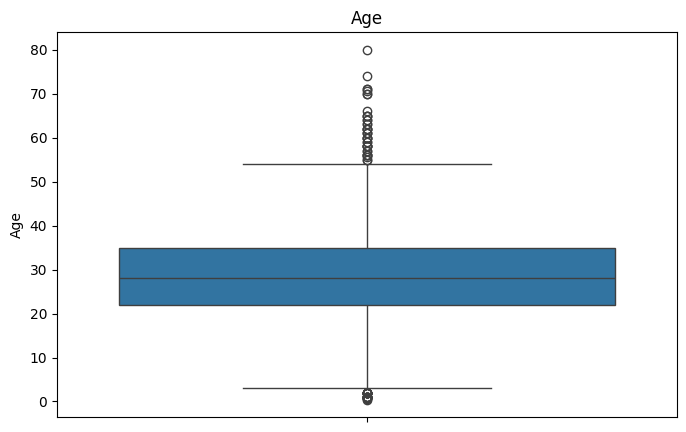

In [24]:
plt.figure(figsize=(8, 5))
sns.boxplot(train_df['Age'])

plt.title('Age')

plt.show()

Мужчин значительно больше

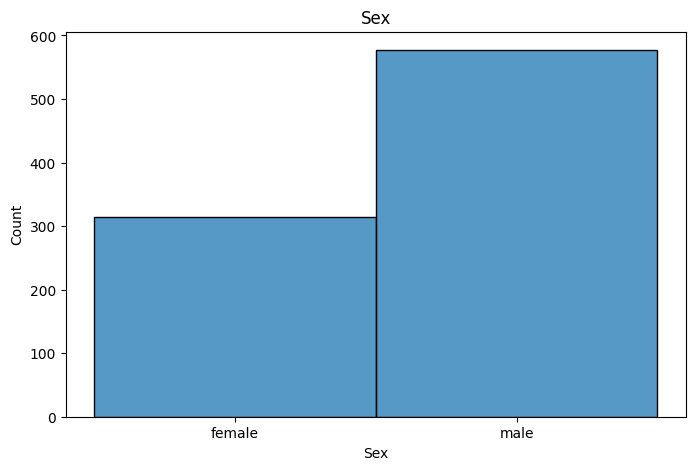

In [25]:
plt.figure(figsize=(8, 5))
sns.histplot(train_df['Sex'])

plt.title('Sex')

plt.show()

Больше всего пассажиров 3 класса

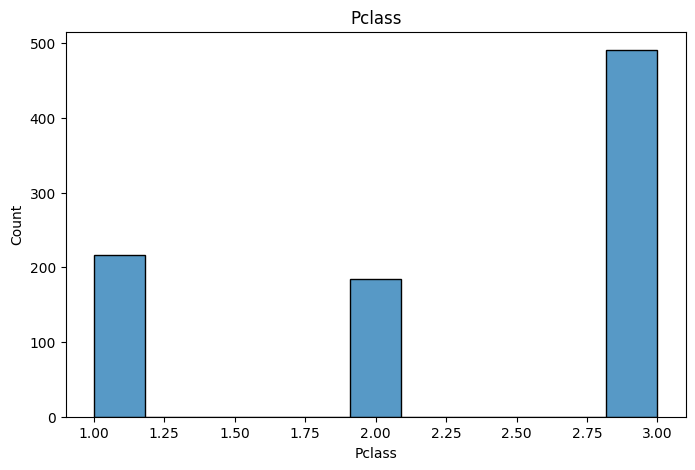

In [26]:
plt.figure(figsize=(8, 5))
sns.histplot(train_df['Pclass'])

plt.title('Pclass')

plt.show()

По рассмотренным признакам можно сделать следующие предположения:

1.  Пол: хотя женщин меньше половины от всех пассажиров, ожидается, что их вероятность выживания будет выше, поэтому среди выживших должно быть больше женщин, чем мужчин, несмотря на то, что мужчин примерно вдвое больше.

2.  Класс билета: большинство пассажиров относится к третьему классу, поэтому предполагается, что наибольшая смертность будет среди пассажиров с самыми дешевыми билетами.

3.  Возраст: средний возраст составляет около 30 лет; вероятно, возраст не окажет решающего влияния на выживание, но всё же внесёт определённый вклад.

Выделим целевую переменную из датасета для дальнейшего моделирования.

In [27]:
y_train = train_df['Survived']
X_train = train_df.drop('Survived', axis=1)

Категориальные признаки оставим для автоматической обработки моделью CatBoost, а числовые признаки подвергнем масштабированию.

In [28]:
numeric_cols = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [29]:
scaler = StandardScaler()
data_scaler = scaler.fit(X_train[numeric_cols])
X_train[numeric_cols] = data_scaler.transform(X_train[numeric_cols])
test_df[numeric_cols] = data_scaler.transform(test_df[numeric_cols])

Дисбаланс классов в данных не является значительным.

In [30]:
y_train.value_counts()

,count
Survived,
0,549
1,342


2.Анализ и построение модели

Объём данных небольшой, и CatBoost хорошо справляется даже без настройки гиперпараметров, поэтому я не буду выделять отдельный валидационный набор. Модель CatBoost выбрана, поскольку она эффективно работает с категориальными признаками.

In [31]:
cat_features = ['Sex', 'Ticket', 'Cabin', 'Embarked']
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(test_df[X_train.columns], cat_features=cat_features)

model = CatBoostClassifier(
    loss_function='Logloss',
)

model.fit(train_pool, eval_set=train_pool, plot=True)
train_preds = model.predict(X_train)
test_preds = model.predict(test_df)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.030798
0:	learn: 0.6740783	test: 0.6751030	best: 0.6751030 (0)	total: 53.8ms	remaining: 53.7s
1:	learn: 0.6632958	test: 0.6643180	best: 0.6643180 (1)	total: 56.5ms	remaining: 28.2s
2:	learn: 0.6439020	test: 0.6448807	best: 0.6448807 (2)	total: 60.8ms	remaining: 20.2s
3:	learn: 0.6309660	test: 0.6321661	best: 0.6321661 (3)	total: 65.5ms	remaining: 16.3s
4:	learn: 0.6180129	test: 0.6193504	best: 0.6193504 (4)	total: 70.8ms	remaining: 14.1s
5:	learn: 0.6052228	test: 0.6060130	best: 0.6060130 (5)	total: 75.2ms	remaining: 12.5s
6:	learn: 0.5921717	test: 0.5929005	best: 0.5929005 (6)	total: 77.8ms	remaining: 11s
7:	learn: 0.5779192	test: 0.5785935	best: 0.5785935 (7)	total: 83.1ms	remaining: 10.3s
8:	learn: 0.5659270	test: 0.5655320	best: 0.5655320 (8)	total: 89.1ms	remaining: 9.81s
9:	learn: 0.5544542	test: 0.5533436	best: 0.5533436 (9)	total: 94.1ms	remaining: 9.32s
10:	learn: 0.5446867	test: 0.5435459	best: 0.5435459 (10)	total: 97.8ms	remaining: 8.79s
11:	learn: 0.

In [32]:
submission = pd.DataFrame({
    'PassengerId': submission['PassengerId'],
    'Survived': test_preds
})


In [33]:
print(f"Recall: {recall_score(train_preds,y_train)}")
print(f"Precision: {precision_score(train_preds,y_train)}")
print(f"F1-score: {f1_score(train_preds,y_train)}")

Recall: 0.9542682926829268
Precision: 0.9152046783625731
F1-score: 0.9343283582089552


3. Интерпретация

In [34]:
cat_explainer = shap.TreeExplainer(
    model, feature_perturbation="tree_path_dependent"
)
cat_shap_values = cat_explainer.shap_values(test_df)

/tmp/ipython-input-3446285147.py:1: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(cat_shap_values,test_df )


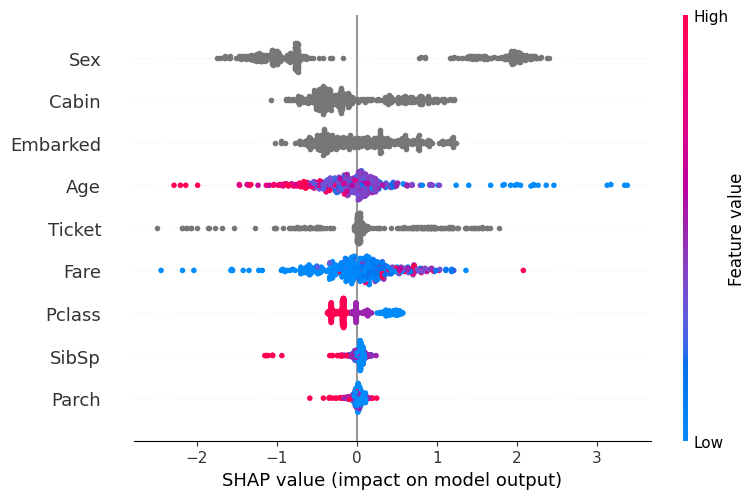

In [35]:

shap.summary_plot(cat_shap_values,test_df )

Итоги анализа признаков:

1.  Пол — оказал ключевое влияние на выживание, что логично, учитывая, что женщин спасали в первую очередь.

2.  Номер каюты — также значимый фактор, что указывает на возможность улучшения точности модели при более тщательной обработке этой переменной.

3.  Возраст — очевидная обратная зависимость: с увеличением возраста вероятность выживания снижается.